In [15]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from networks import RobotActorNetwork, RobotCriticNetwork
from replaybuffer import RobotReplayBuffer
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from matplotlib.animation import FuncAnimation
from matplotlib import rc, animation
from math import cos, sin, exp
from utilities import reset, kinematics, dynamics, distance, step, space_robot_parameters
from numpy.random import seed
from ddpg_agent import Agent
from numpy import random
from scipy.interpolate import splrep, BSpline

In [16]:
# Space robot parameters
params = space_robot_parameters()

# Initial position
state = reset()
initial_pos, Jacobian =  kinematics(state,params)
# Goal position of the end-effector
ee_final_x = 0.99999044 
ee_final_y = -0.18
ee_orient_fin = 1.5708 
goal_pos = [ee_final_x, ee_final_y, ee_orient_fin]

# Hyper parameters
dt = 0.01
max_iterations = 200
max_action = 0.2
min_action = -0.2
action_size = 3
state_size = 12
state_action_size = state_size + action_size
replay_buffer_size = 1000000
batch_size = 64*5
start_to_train = 10
random_sample = 1
mean = 0
standard_deviation = 0.1
gamma = 0.99
tau = 0.005
actor_lr = 0.01
critic_lr = 0.01
nr_of_episodes = 1000
nr_of_steps = 200  # 2 seconds
seed_nr = 42

In [17]:
seed(seed_nr)
tf.random.set_seed(seed_nr) 

agent = Agent(actor_lr, critic_lr, gamma, tau, state_size, action_size, state_action_size, replay_buffer_size, mean,
              standard_deviation, min_action, max_action, batch_size, random_sample)


In [18]:
# Testing before training

seed(seed_nr)
tf.random.set_seed(seed_nr) 

sat_pos_x = np.zeros(max_iterations)
sat_pos_y = np.zeros(max_iterations)
sat_orient = np.zeros(max_iterations)
joint_1 = np.zeros(max_iterations)
joint_2 = np.zeros(max_iterations)
joint_3 = np.zeros(max_iterations)

state = reset()

sat_pos_x[0] = state[0]
sat_pos_y[0] = state[1]
sat_orient[0] = state[2]
joint_1[0] = state[3]
joint_2[0] = state[4]
joint_3[0] = state[5] 
EE = np.zeros((max_iterations,3))
EE[0,:], Jacobian = kinematics(state,params)

for i in range(1,max_iterations):    
    action_tf = agent.take_action(state,0)
    next_state, new_EE, done, reward = step(state,action_tf,params,dt,initial_pos,goal_pos,max_action,0,0,0)    
    state = next_state  
    EE[i,:],Jacobian = kinematics(state,params)
    sat_pos_x[i] = state[0]
    sat_pos_y[i] = state[1]
    sat_orient[i] = state[2]
    joint_1[i] = state[3]
    joint_2[i] = state[4]
    joint_3[i] = state[5]    
        
p1 = params[0] 
p2 = params[1] 
a1 = params[2] 
a2 = params[3] 
a3 = params[4] 
L1 = params[5] 
L2 = params[6] 
L3 = params[7] 
m0 = params[8] 
m1 = params[9] 
m2 = params[10] 
m3 = params[11] 
I0 = params[12] 
I1 = params[13] 
I2 = params[14] 
I3 = params[15] 
    
BaseXwn = np.zeros(max_iterations)
BaseYwn = np.zeros(max_iterations)
BaseXws = np.zeros(max_iterations)
BaseYws = np.zeros(max_iterations) 
BaseXen = np.zeros(max_iterations)
BaseYen = np.zeros(max_iterations)
BaseXes = np.zeros(max_iterations)
BaseYes = np.zeros(max_iterations)
Link1Xws = np.zeros(max_iterations) 
Link1Yws = np.zeros(max_iterations) 
Link1Xwn = np.zeros(max_iterations) 
Link1Ywn = np.zeros(max_iterations) 
Link1Xes = np.zeros(max_iterations) 
Link1Yes = np.zeros(max_iterations) 
Link1Xen = np.zeros(max_iterations) 
Link1Yen = np.zeros(max_iterations) 
MPXws = np.zeros(max_iterations)
MPYws = np.zeros(max_iterations)
MPXwn = np.zeros(max_iterations)
MPYwn = np.zeros(max_iterations)
MPXes = np.zeros(max_iterations)
MPYes = np.zeros(max_iterations)
MPXen = np.zeros(max_iterations)
MPYen = np.zeros(max_iterations)
Link2Xws = np.zeros(max_iterations) 
Link2Yws = np.zeros(max_iterations) 
Link2Xwn = np.zeros(max_iterations) 
Link2Ywn = np.zeros(max_iterations) 
Link2Xes = np.zeros(max_iterations) 
Link2Yes = np.zeros(max_iterations) 
Link2Xen = np.zeros(max_iterations) 
Link2Yen = np.zeros(max_iterations) 
Link3Xws = np.zeros(max_iterations) 
Link3Yws = np.zeros(max_iterations) 
Link3Xwn = np.zeros(max_iterations) 
Link3Ywn = np.zeros(max_iterations) 
Link3Xes = np.zeros(max_iterations) 
Link3Yes = np.zeros(max_iterations) 
Link3Xen = np.zeros(max_iterations) 
Link3Yen = np.zeros(max_iterations) 
MPL1X = np.zeros(max_iterations)
MPL1Y = np.zeros(max_iterations)
L1L2X = np.zeros(max_iterations)
L1L2Y = np.zeros(max_iterations)
L2L3X = np.zeros(max_iterations)
L2L3Y = np.zeros(max_iterations)

satellite_edge = 0.5

d1 = 0.25
d2 = 0.025

for j in range(0,max_iterations):
    satWN = [[sat_pos_x[j]-satellite_edge/2, sat_pos_y[j] +satellite_edge/2]]
    satWS = [[sat_pos_x[j]-satellite_edge/2, sat_pos_y[j] -satellite_edge/2]]
    satEN = [[sat_pos_x[j]+satellite_edge/2, sat_pos_y[j] +satellite_edge/2]]
    satES = [[sat_pos_x[j]+satellite_edge/2, sat_pos_y[j] -satellite_edge/2]]
    rotation_matrix = [[cos(sat_orient[j]), sin(sat_orient[j])], [-sin(sat_orient[j]), cos(sat_orient[j])]]
    rotation_matrix = np.transpose(rotation_matrix)
    satwn = np.matmul(rotation_matrix,np.transpose(np.subtract(satWN,[[sat_pos_x[j], sat_pos_y[j]]])))
    satws = np.matmul(rotation_matrix,np.transpose(np.subtract(satWS,[[sat_pos_x[j], sat_pos_y[j]]])))
    saten = np.matmul(rotation_matrix,np.transpose(np.subtract(satEN,[[sat_pos_x[j], sat_pos_y[j]]])))
    sates = np.matmul(rotation_matrix,np.transpose(np.subtract(satES,[[sat_pos_x[j], sat_pos_y[j]]])))
    satWN = np.add(np.transpose(satwn), [[sat_pos_x[j], sat_pos_y[j]]])
    satWS = np.add(np.transpose(satws), [[sat_pos_x[j], sat_pos_y[j]]])
    satEN = np.add(np.transpose(saten), [[sat_pos_x[j], sat_pos_y[j]]])
    satES = np.add(np.transpose(sates), [[sat_pos_x[j], sat_pos_y[j]]])
    BaseXwn[j] = satWN[0][0]
    BaseYwn[j] = satWN[0][1]
    BaseXws[j] = satWS[0][0]
    BaseYws[j] = satWS[0][1]    
    BaseXen[j] = satEN[0][0]
    BaseYen[j] = satEN[0][1]   
    BaseXes[j] = satES[0][0]
    BaseYes[j] = satES[0][1]
    MPXws[j] = sat_pos_x[j] + d1*cos(sat_orient[j]) - (p2-d2)*sin(sat_orient[j])
    MPYws[j] = sat_pos_y[j] + d1*sin(sat_orient[j]) + (p2-d2)*cos(sat_orient[j])
    MPXwn[j] = sat_pos_x[j] + d1*cos(sat_orient[j]) - (d2+p2)*sin(sat_orient[j])
    MPYwn[j] = sat_pos_y[j] + d1*sin(sat_orient[j]) + (d2+p2)*cos(sat_orient[j])
    MPXes[j] = MPXws[j] + (p1-0.25)*cos(sat_orient[j])
    MPYes[j] = MPYws[j] + (p1-0.25)*sin(sat_orient[j])
    MPXen[j] = MPXwn[j] + (p1-0.25)*cos(sat_orient[j])
    MPYen[j] = MPYwn[j] + (p1-0.25)*sin(sat_orient[j])
    MPL1X[j] = (MPXes[j]+MPXen[j])/2
    MPL1Y[j] = (MPYes[j]+MPYen[j])/2
    Link1Xws[j] = MPL1X[j] + d2*sin(sat_orient[j]+joint_1[j])
    Link1Yws[j] = MPL1Y[j] - d2*cos(sat_orient[j]+joint_1[j])
    Link1Xwn[j] = MPL1X[j] - d2*sin(sat_orient[j]+joint_1[j])
    Link1Ywn[j] = MPL1Y[j] + d2*cos(sat_orient[j]+joint_1[j])
    Link1Xes[j] = Link1Xws[j] + L1*cos(sat_orient[j]+joint_1[j])
    Link1Yes[j] = Link1Yws[j] + L1*sin(sat_orient[j]+joint_1[j])
    Link1Xen[j] = Link1Xwn[j] + L1*cos(sat_orient[j]+joint_1[j])
    Link1Yen[j] = Link1Ywn[j] + L1*sin(sat_orient[j]+joint_1[j])
    L1L2X[j] = (Link1Xes[j]+Link1Xen[j])/2
    L1L2Y[j] = (Link1Yes[j]+Link1Yen[j])/2
    Link2Xws[j] = L1L2X[j] + d2*sin(sat_orient[j]+joint_1[j]+joint_2[j])
    Link2Yws[j] = L1L2Y[j] - d2*cos(sat_orient[j]+joint_1[j]+joint_2[j])
    Link2Xwn[j] = L1L2X[j] - d2*sin(sat_orient[j]+joint_1[j]+joint_2[j])
    Link2Ywn[j] = L1L2Y[j] + d2*cos(sat_orient[j]+joint_1[j]+joint_2[j])
    Link2Xes[j] = Link2Xws[j] + L2*cos(sat_orient[j]+joint_1[j]+joint_2[j])
    Link2Yes[j] = Link2Yws[j] + L2*sin(sat_orient[j]+joint_1[j]+joint_2[j])
    Link2Xen[j] = Link2Xwn[j] + L2*cos(sat_orient[j]+joint_1[j]+joint_2[j])
    Link2Yen[j] = Link2Ywn[j] + L2*sin(sat_orient[j]+joint_1[j]+joint_2[j])    
    L2L3X[j] = (Link2Xes[j]+Link2Xen[j])/2
    L2L3Y[j] = (Link2Yes[j]+Link2Yen[j])/2
    Link3Xws[j] = L2L3X[j] + d2*sin(sat_orient[j]+joint_1[j]+joint_2[j]+joint_3[j])
    Link3Yws[j] = L2L3Y[j] - d2*cos(sat_orient[j]+joint_1[j]+joint_2[j]+joint_3[j])
    Link3Xwn[j] = L2L3X[j] - d2*sin(sat_orient[j]+joint_1[j]+joint_2[j]+joint_3[j])
    Link3Ywn[j] = L2L3Y[j] + d2*cos(sat_orient[j]+joint_1[j]+joint_2[j]+joint_3[j])
    Link3Xes[j] = Link3Xws[j] + L3*cos(sat_orient[j]+joint_1[j]+joint_2[j]+joint_3[j])
    Link3Yes[j] = Link3Yws[j] + L3*sin(sat_orient[j]+joint_1[j]+joint_2[j]+joint_3[j])
    Link3Xen[j] = Link3Xwn[j] + L3*cos(sat_orient[j]+joint_1[j]+joint_2[j]+joint_3[j])
    Link3Yen[j] = Link3Ywn[j] + L3*sin(sat_orient[j]+joint_1[j]+joint_2[j]+joint_3[j])
    
# Animation

%matplotlib qt

fig = plt.figure()

ax = fig.add_subplot(111)

plt.axis('equal')

ax.set_xlim(-1, 2)
ax.set_ylim(-1, 1)

xdata, ydata = [], []
ee, = plt.plot([], [], 'r', animated=False)

Base  = np.array([[BaseXws[0],BaseYws[0]],[BaseXes[0],BaseYes[0]],[BaseXen[0],BaseYen[0]],[BaseXwn[0],BaseYwn[0]],[BaseXws[0],BaseYws[0]]])
MP = np.array([[MPXws[0],MPYws[0]], [MPXes[0],MPYes[0]], [MPXen[0],MPYen[0]], [MPXwn[0],MPYwn[0]], [MPXws[0],MPYws[0]]])
Link1 = np.array([[Link1Xws[0],Link1Yws[0]], [Link1Xes[0],Link1Yes[0]], [Link1Xen[0],Link1Yen[0]], [Link1Xwn[0],Link1Ywn[0]], [Link1Xws[0],Link1Yws[0]]])
Link2 = np.array([[Link2Xws[0],Link2Yws[0]], [Link2Xes[0],Link2Yes[0]], [Link2Xen[0],Link2Yen[0]], [Link2Xwn[0],Link2Ywn[0]], [Link2Xws[0],Link2Yws[0]]])
Link3 = np.array([[Link3Xws[0],Link3Yws[0]], [Link3Xes[0],Link3Yes[0]], [Link3Xen[0],Link3Yen[0]], [Link3Xwn[0],Link3Ywn[0]], [Link3Xws[0],Link3Yws[0]]])

kwds = dict(ec='k', alpha=0.5)
patches = [ax.add_patch(plt.Polygon(0 * Base, fc='b', **kwds)),
           ax.add_patch(plt.Polygon(0 * MP, fc='b', **kwds)),
           ax.add_patch(plt.Polygon(0 * Link1, fc='darkkhaki', **kwds)),
           ax.add_patch(plt.Polygon(0 * Link2, fc='darkkhaki', **kwds)),
           ax.add_patch(plt.Polygon(0 * Link3, fc='darkkhaki', **kwds)),
           ax.add_patch(plt.Circle((0,0),0.04, fc="dimgrey")),
           ax.add_patch(plt.Circle((0,0),0.04, fc="dimgrey")),
           ax.add_patch(plt.Circle((0,0),0.04, fc="dimgrey"))]



def SpaRobAnim(i):
    temp1 = [[BaseXws[i],BaseYws[i]],[BaseXes[i],BaseYes[i]],[BaseXen[i],BaseYen[i]],[BaseXwn[i],BaseYwn[i]],[BaseXws[i],BaseYws[i]]]
    patches[0].set_xy(temp1)
    temp2 = [[MPXws[i],MPYws[i]], [MPXes[i],MPYes[i]], [MPXen[i],MPYen[i]], [MPXwn[i],MPYwn[i]], [MPXws[i],MPYws[i]]]
    patches[1].set_xy(temp2)
    temp3 = [[Link1Xws[i],Link1Yws[i]], [Link1Xes[i],Link1Yes[i]], [Link1Xen[i],Link1Yen[i]], [Link1Xwn[i],Link1Ywn[i]], [Link1Xws[i],Link1Yws[i]]]
    patches[2].set_xy(temp3)
    temp4 = [[Link2Xws[i],Link2Yws[i]], [Link2Xes[i],Link2Yes[i]], [Link2Xen[i],Link2Yen[i]], [Link2Xwn[i],Link2Ywn[i]], [Link2Xws[i],Link2Yws[i]]]
    patches[3].set_xy(temp4)
    temp5 = [[Link3Xws[i],Link3Yws[i]], [Link3Xes[i],Link3Yes[i]], [Link3Xen[i],Link3Yen[i]], [Link3Xwn[i],Link3Ywn[i]], [Link3Xws[i],Link3Yws[i]]]
    patches[4].set_xy(temp5)
    patches[5].center = (MPL1X[i],MPL1Y[i])
    patches[6].center = (L1L2X[i],L1L2Y[i])
    patches[7].center = (L2L3X[i],L2L3Y[i])
    xdata.append(EE[i,0])
    ydata.append(EE[i,1])
    ee.set_data(xdata,ydata)
    return patches, ee

def init():
    ee.set_data(xdata,ydata)
    return ee

anim = animation.FuncAnimation(fig, SpaRobAnim,
                               frames=np.arange(0,len(BaseYes),1),
                               interval=10, blit=False, repeat=False,init_func=init)

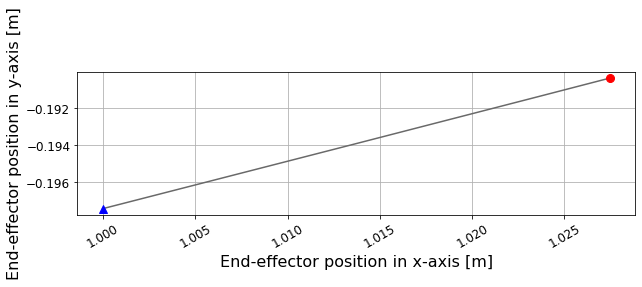

In [19]:
%matplotlib inline
fig_font = {'color':'black','size':16}

nr_of_rows = 1
nr_of_columns = 1

fig = plt.figure(figsize=(10, 12))

ax = fig.add_subplot(nr_of_rows, nr_of_columns, 1)
ax.plot(EE[:,0], EE[:,1], color='dimgray')
plt.plot(EE[0,0], EE[0,1], 'b^', markersize=8)
plt.plot(EE[-1,0], EE[-1,1], 'ro', markersize=8)
plt.gca().set_aspect('equal')
plt.xlabel("End-effector position in x-axis [m]", fontdict=fig_font)
plt.ylabel("End-effector position in y-axis [m]", fontdict=fig_font)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation = 30)
plt.grid()

plt.show()

EE_bef_train = EE

In [22]:
# Deep Deterministic Policy Gradient algorithm

reward_plot = np.zeros(nr_of_episodes)
id_plot = -1

for episode in range(nr_of_episodes):
    state = reset()   
    time_act = 0
    reward_sum = 0
    for s in range(nr_of_steps):
        action_tf = agent.take_action(state, 1)
        next_state, new_EE, done, reward = step(state,action_tf,params,dt,initial_pos,goal_pos,max_action,nr_of_steps*0.01,time_act,1)
        state_mod = state.reshape(1,12)
        next_state_mod = next_state.reshape(1,12)
        action_mod = (action_tf.numpy().reshape(1,3))
        reward = np.array(reward)
        reward_sum = reward_sum + reward
        reward_mod = reward.reshape(1)
        agent.store_transition(state_mod, action_mod, next_state_mod, reward_mod)
        if episode >= start_to_train:
            agent.training()        
        state = next_state  
        time_act = time_act + dt
    if episode >= start_to_train:
        id_plot = id_plot + 1
        reward_plot[id_plot] = reward_sum
        print("Episode nr {}  Reward is {}".format(episode,reward_sum))
    else:
        print("Episode nr {}".format(episode))
        

Text(0, 0.5, 'Reward')

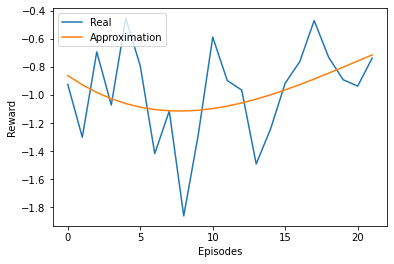

In [8]:
# Reward at each episode

%matplotlib inline
id_reward = np.arange(0,id_plot)
tck = splrep(id_reward, reward_plot[:id_plot], s=10)
plt.plot(id_reward, reward_plot[:id_plot], label='Real')
plt.plot(id_reward, BSpline(*tck)(id_reward), label='Approximation')
plt.legend(loc="upper left")
plt.xlabel("Episodes")
plt.ylabel("Reward")

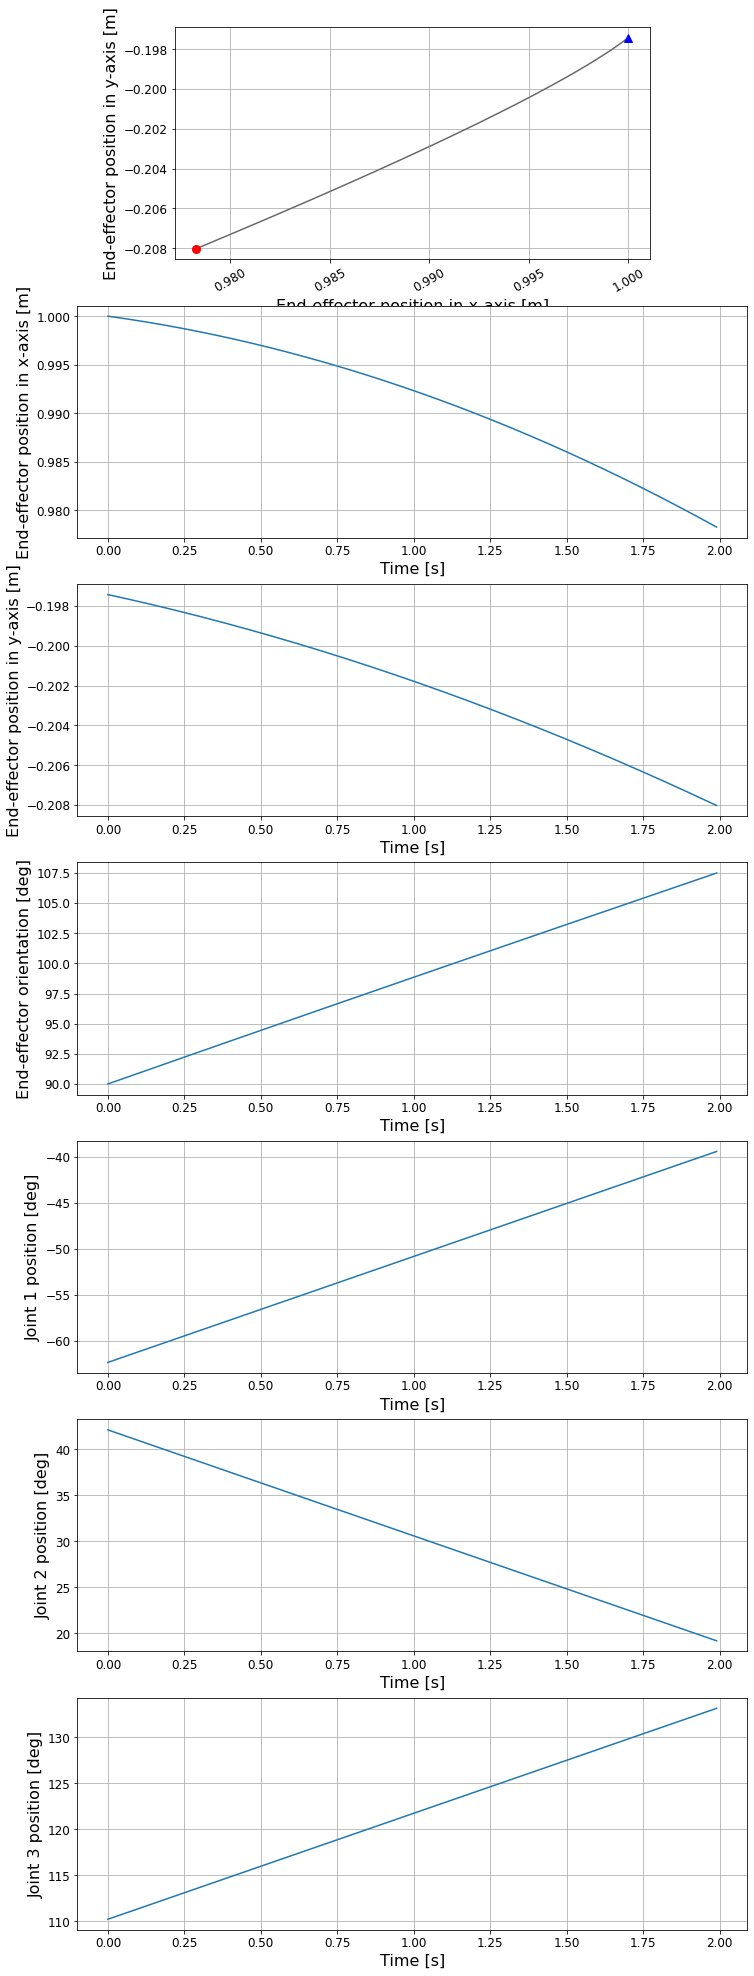

In [51]:
# Some plots

%matplotlib inline
fig_font = {'color':'black','size':16}

nr_of_rows = 7
nr_of_columns = 1

fig = plt.figure(figsize=(12, 35))

ax = fig.add_subplot(nr_of_rows, nr_of_columns, 1)
ax.plot(EE[:,0], EE[:,1], color='dimgray')
plt.plot(EE[0,0], EE[0,1], 'b^', markersize=8)
plt.plot(EE[-1,0], EE[-1,1], 'ro', markersize=8)
plt.gca().set_aspect('equal')
plt.xlabel("End-effector position in x-axis [m]", fontdict=fig_font)
plt.ylabel("End-effector position in y-axis [m]", fontdict=fig_font)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation = 30)
plt.grid()

ax = fig.add_subplot(nr_of_rows, nr_of_columns, 2)
ax.plot(sim_time, EE[:,0])
plt.xlabel("Time [s]", fontdict=fig_font)
plt.ylabel("End-effector position in x-axis [m]", fontdict=fig_font)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

ax = fig.add_subplot(nr_of_rows, nr_of_columns, 3)
ax.plot(sim_time, EE[:,1])
plt.xlabel("Time [s]", fontdict=fig_font)
plt.ylabel("End-effector position in y-axis [m]", fontdict=fig_font)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

ax = fig.add_subplot(nr_of_rows, nr_of_columns, 4)
ax.plot(sim_time, EE[:,2]*180/math.pi)
plt.xlabel("Time [s]", fontdict=fig_font)
plt.ylabel("End-effector orientation [deg]", fontdict=fig_font)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()


ax = fig.add_subplot(nr_of_rows, nr_of_columns, 5)
ax.plot(sim_time, joint_1*180/math.pi)
plt.xlabel("Time [s]", fontdict=fig_font)
plt.ylabel("Joint 1 position [deg]", fontdict=fig_font)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

ax = fig.add_subplot(nr_of_rows, nr_of_columns, 6)
ax.plot(sim_time, joint_2*180/math.pi)
plt.xlabel("Time [s]", fontdict=fig_font)
plt.ylabel("Joint 2 position [deg]", fontdict=fig_font)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

ax = fig.add_subplot(nr_of_rows, nr_of_columns, 7)
ax.plot(sim_time, joint_3*180/math.pi)
plt.xlabel("Time [s]", fontdict=fig_font)
plt.ylabel("Joint 3 position [deg]", fontdict=fig_font)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()



plt.show()

fig.tight_layout(pad=15.0)
